# Parallelizing analysis

As we approach the exascale barrier, researchers are handling increasingly large volumes of molecular dynamics (MD) data. Whilst MDAnalysis is a flexible and relatively fast framework for complex analysis tasks in MD simulations, implementing a parallel computing framework would play a pivotal role in accelerating the time to solution for such large datasets.	

This document illustrates how you can run your own analysis scripts in parallel with MDAnalysis.

**Last executed:** Aug 13, 2020 with MDAnalysis 2.0.0

**Last updated:** August 2020

**Minimum version of MDAnalysis:** 2.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisData
* dask (<a href="https://dask.org/">https://dask.org/</a>)
* dask.distributed (<a href="https://distributed.dask.org/en/latest/">https://distributed.dask.org/en/latest/</a>)  
* joblib (<a href="https://joblib.readthedocs.io/en/latest/">https://joblib.readthedocs.io/en/latest/</a>)

In [33]:
import MDAnalysis as mda
from MDAnalysisData.adk_equilibrium import fetch_adk_equilibrium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import cpu_count
n_jobs = cpu_count()

## Backgroud

In MDAnalysis, most implemented analysis methods are based on `AnalysisBase`, which provides a generic API for users to <a href=https://mdanalysis.org/UserGuide/examples/analysis/custom_trajectory_analysis.html>write their own trajectory analysis</a>. However, this framework only takes single-core power of the PC by iterating the trajectory and running a frame-wise analysis. Below we aim to first explore some possible simple implementations of paralleism, including using multiprocessing and dask. We will also discuss the acceleration approaches that should be considered ranging from your own multiple-core laptops/desktops to distributed clusters in the HPC center.  

### Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosopho-transferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>). The trajectory has 4187 frames, which will take quite some time to run the analysis on with the conventional serial (single-core) approach.

Note: downloading these datasets from MDAnalysisData may take some time.

In [2]:
adk = fetch_adk_equilibrium()
u = mda.Universe(adk.topology, adk.trajectory)
protein = u.select_atoms('protein')

In [3]:
u.trajectory

<DCDReader /home/scottzhuang/MDAnalysis_data/adk_equilibrium/1ake_007-nowater-core-dt240ps.dcd with 4187 frames of 3341 atoms>

### Radius of gyration
For detail description of this analysis, read [Writing your own trajectory](https://mdanalysis.org/UserGuide/examples/analysis/custom_trajectory_analysis.html).

Here is a common form of single-frame method that we can normally see inside `AnalysisBase`. It may contain both some dynamic parts that changes along time either implicitly or explicitly (e.g. `AtomGroup`) and some static parts (e.g. a reference frame).

In [4]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

### Serial Analysis

Below is the serial version of the analysis that we normally use.

In [5]:
result = []
for frame in u.trajectory:
    result.append(radgyr(atomgroup=protein,
                         masses=protein.masses,
                         total_mass=np.sum(protein.masses)))

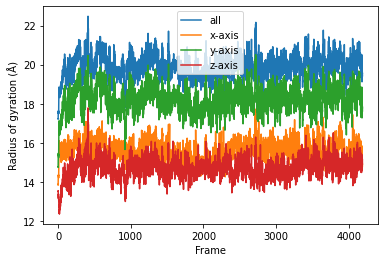

In [6]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

## Parallelization in a simple per-frame fashion

### Frame-wise form of the function

First, we need to modify the single-frame method to contain the `frame_index`. Then we explicitly point to the frame that need to be analyzed: `atomgroup.universe.trajectory[frame_index]`. With that, the state of all the dynamic components will change accordingly (e.g. the position of the `AtomGroup`)

In [7]:
def radgyr_per_frame(frame_index, atomgroup, masses, total_mass=None):
    atomgroup.universe.trajectory[frame_index]
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

### Parallelization with multiprocess

The native parallel module in python is called [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing), it contains some useful tools to build a pool of working cores, map the function into different workers, and gather and order the results from all the workers.

Below we use `Pool` from `multiprocessing` as a context manager, we can define how many cores (or workers) we want tu use. By `Pool(n_jobs)`. Then we can map our analysis method `radgyr_per_frame` with the parameters needed with `partial`. Note we do not include `frame_index` inside partial, because `frame_index` is the variable that is iterated to create a list of jobs.

The downside of `multiprocessing` is that it is mostly focused on single-machine multicore parallelism (without extra manager). It is hard to operate on multimachine conditions (we use `dask` instead) 

In [8]:
import multiprocessing
from multiprocessing import Pool
from functools import partial

In [9]:
with Pool(n_jobs) as worker_pool:
    result = worker_pool.map(partial(radgyr_per_frame, 
                                     atomgroup=protein,
                                     masses=protein.masses,
                                     total_mass=np.sum(protein.masses)),
                             range(u.trajectory.n_frames))

The `result` will be a list of arrays containing the result for each frame.
Finally the results can be plotted along time.

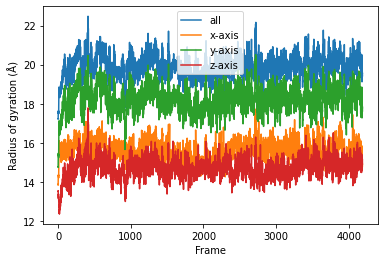

In [10]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

### Parallelization with dask

Dask is a flexible library for parallel computing in Python. It provides advanced parallelism for analytics that has been intergrated or ultilized in many scientific softwares. It can be scaled from one single computer to a cluster of computers inside a HPC center.

It has a dynamic task scheduling that can be used either in synchronous (single-core), threading, multiprocess or distributed cluster. A very simple function in dask, `dask.delayed`, mimics for loops and wraps custom normal python code into a dask graph. Then it can be easily visulized by `dask.visualize()` to examine if the task is well distributed. 

Below is a simple example to use Dask to achieve the same task as `multiprocess` does.

The API of Dask is similiar to `multiprocessing`. It also creates a pool of workers for your single machine with the given resources.

Note: The threaded scheduler in dask (similar to `threading` in python) should not be used as it will mess up with the state (timestep) of the trajectory.

In [11]:
import dask
import dask.multiprocessing
dask.config.set(scheduler='processes')

Below is how you can ultilize `dask.distributed` module to build a local cluster.

Note: this is not really needed for your laptop/desktop. Using dask.distributed may even slow down the performance, but it provides a diagnostic dashboard that can provide valuable insight on performance and progress.

See limitations here: https://distributed.dask.org/en/latest/limitations.html

In [12]:
from dask.distributed import Client

client = Client(n_workers=n_jobs)
client

Client Scheduler: tcp://127.0.0.1:38003 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.49 GB


First we have to create a list of jobs and transform them with `dask.delayed()` so they can be processed by Dask.

In [13]:
job_list = []
for frame_index in range(u.trajectory.n_frames):
    job_list.append(dask.delayed(radgyr_per_frame(frame_index,
                                        atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

Then we simply use `dask.compute()` to get a list of ordered results.

In [14]:
result = dask.compute(job_list)

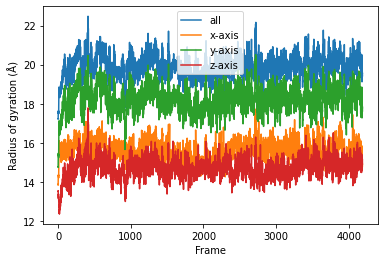

In [15]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

We can also use the old `radgyr` function because `dask` is more flexible on the input args.

Note: `protein` will change its state during the trajectory iteration, so the processes are always aware which timestep the trajectory is in and change the `protein` (e.g. positions) accordingly.

In [16]:
job_list = []
for frame in u.trajectory:
    job_list.append(dask.delayed(radgyr(atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

Then we simply use `dask.compute()` to get a list of ordered results.

In [17]:
result = dask.compute(job_list)

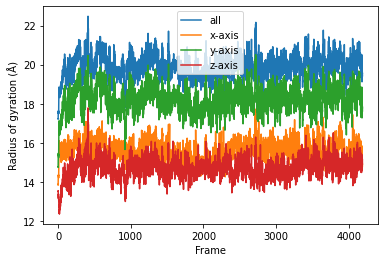

In [18]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

We can also use Dask dashboard (with dask.distributed.Client) to examine how jobs are distributed along all the workers. So each green bar below reprsents a single-frame `radgyr`.

<div>
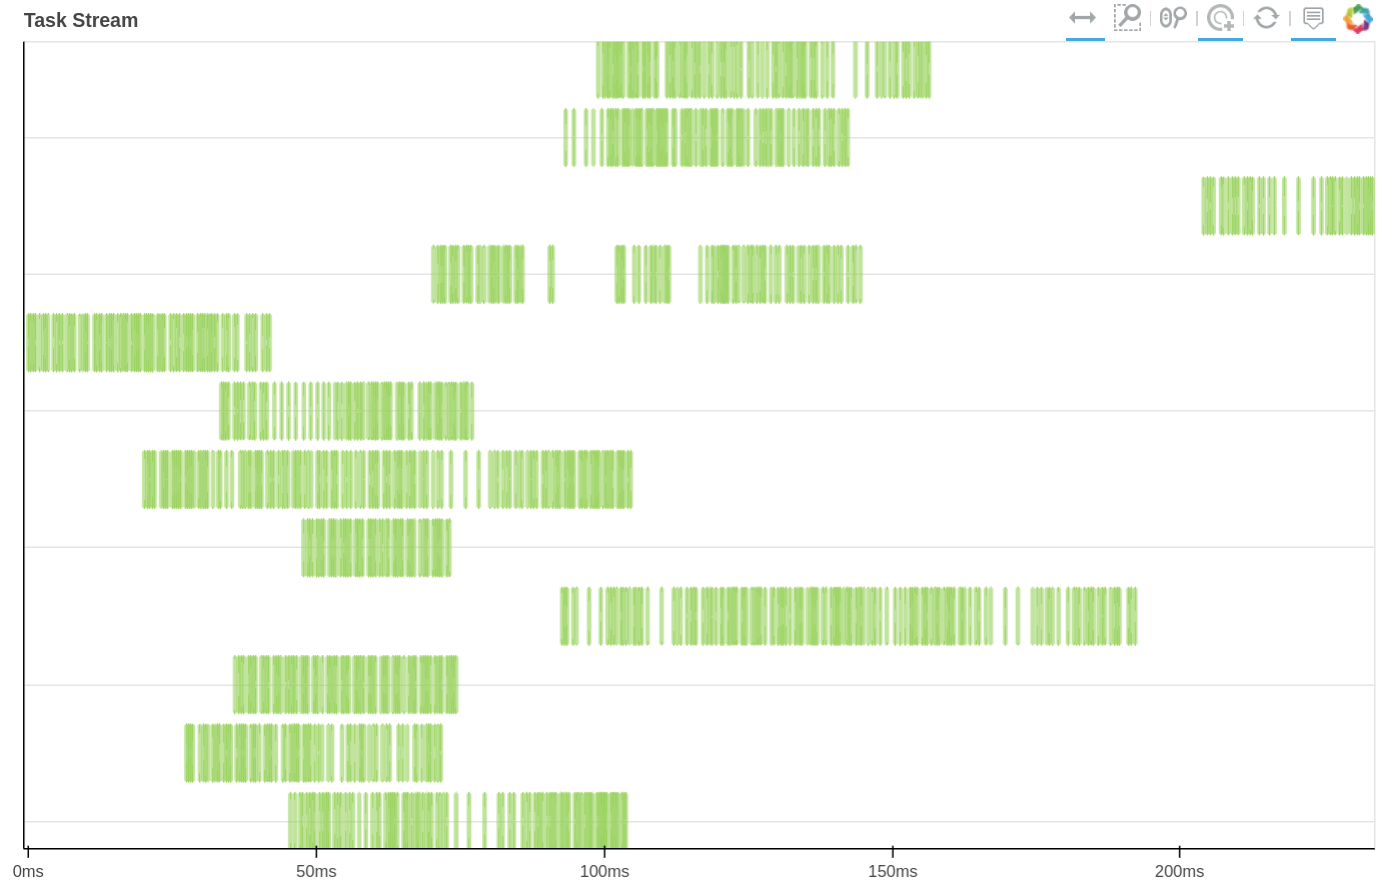
</div>

## Parallelization in a split-apply-combine fashion

The aforementioned per-frame approach should normally be **avoided** because in each task, all the attributes (`AtomGroup`, `Universe`, and etc) need to be pickled. This might even takes more time than your lightweight analysis! Besides, e.g. in dask, a huge amount of time is needed overhead to build a comprehensive dask graph with thousands of tasks.

So a simple split-apply-combine scheme for parallel trajectory analysis should normally to applied (See the figure below)--the trajectory is split into blocks, analysis is performed separately and in parallel on each block ("apply"), then results from each block are gathered and combined. 

<div>
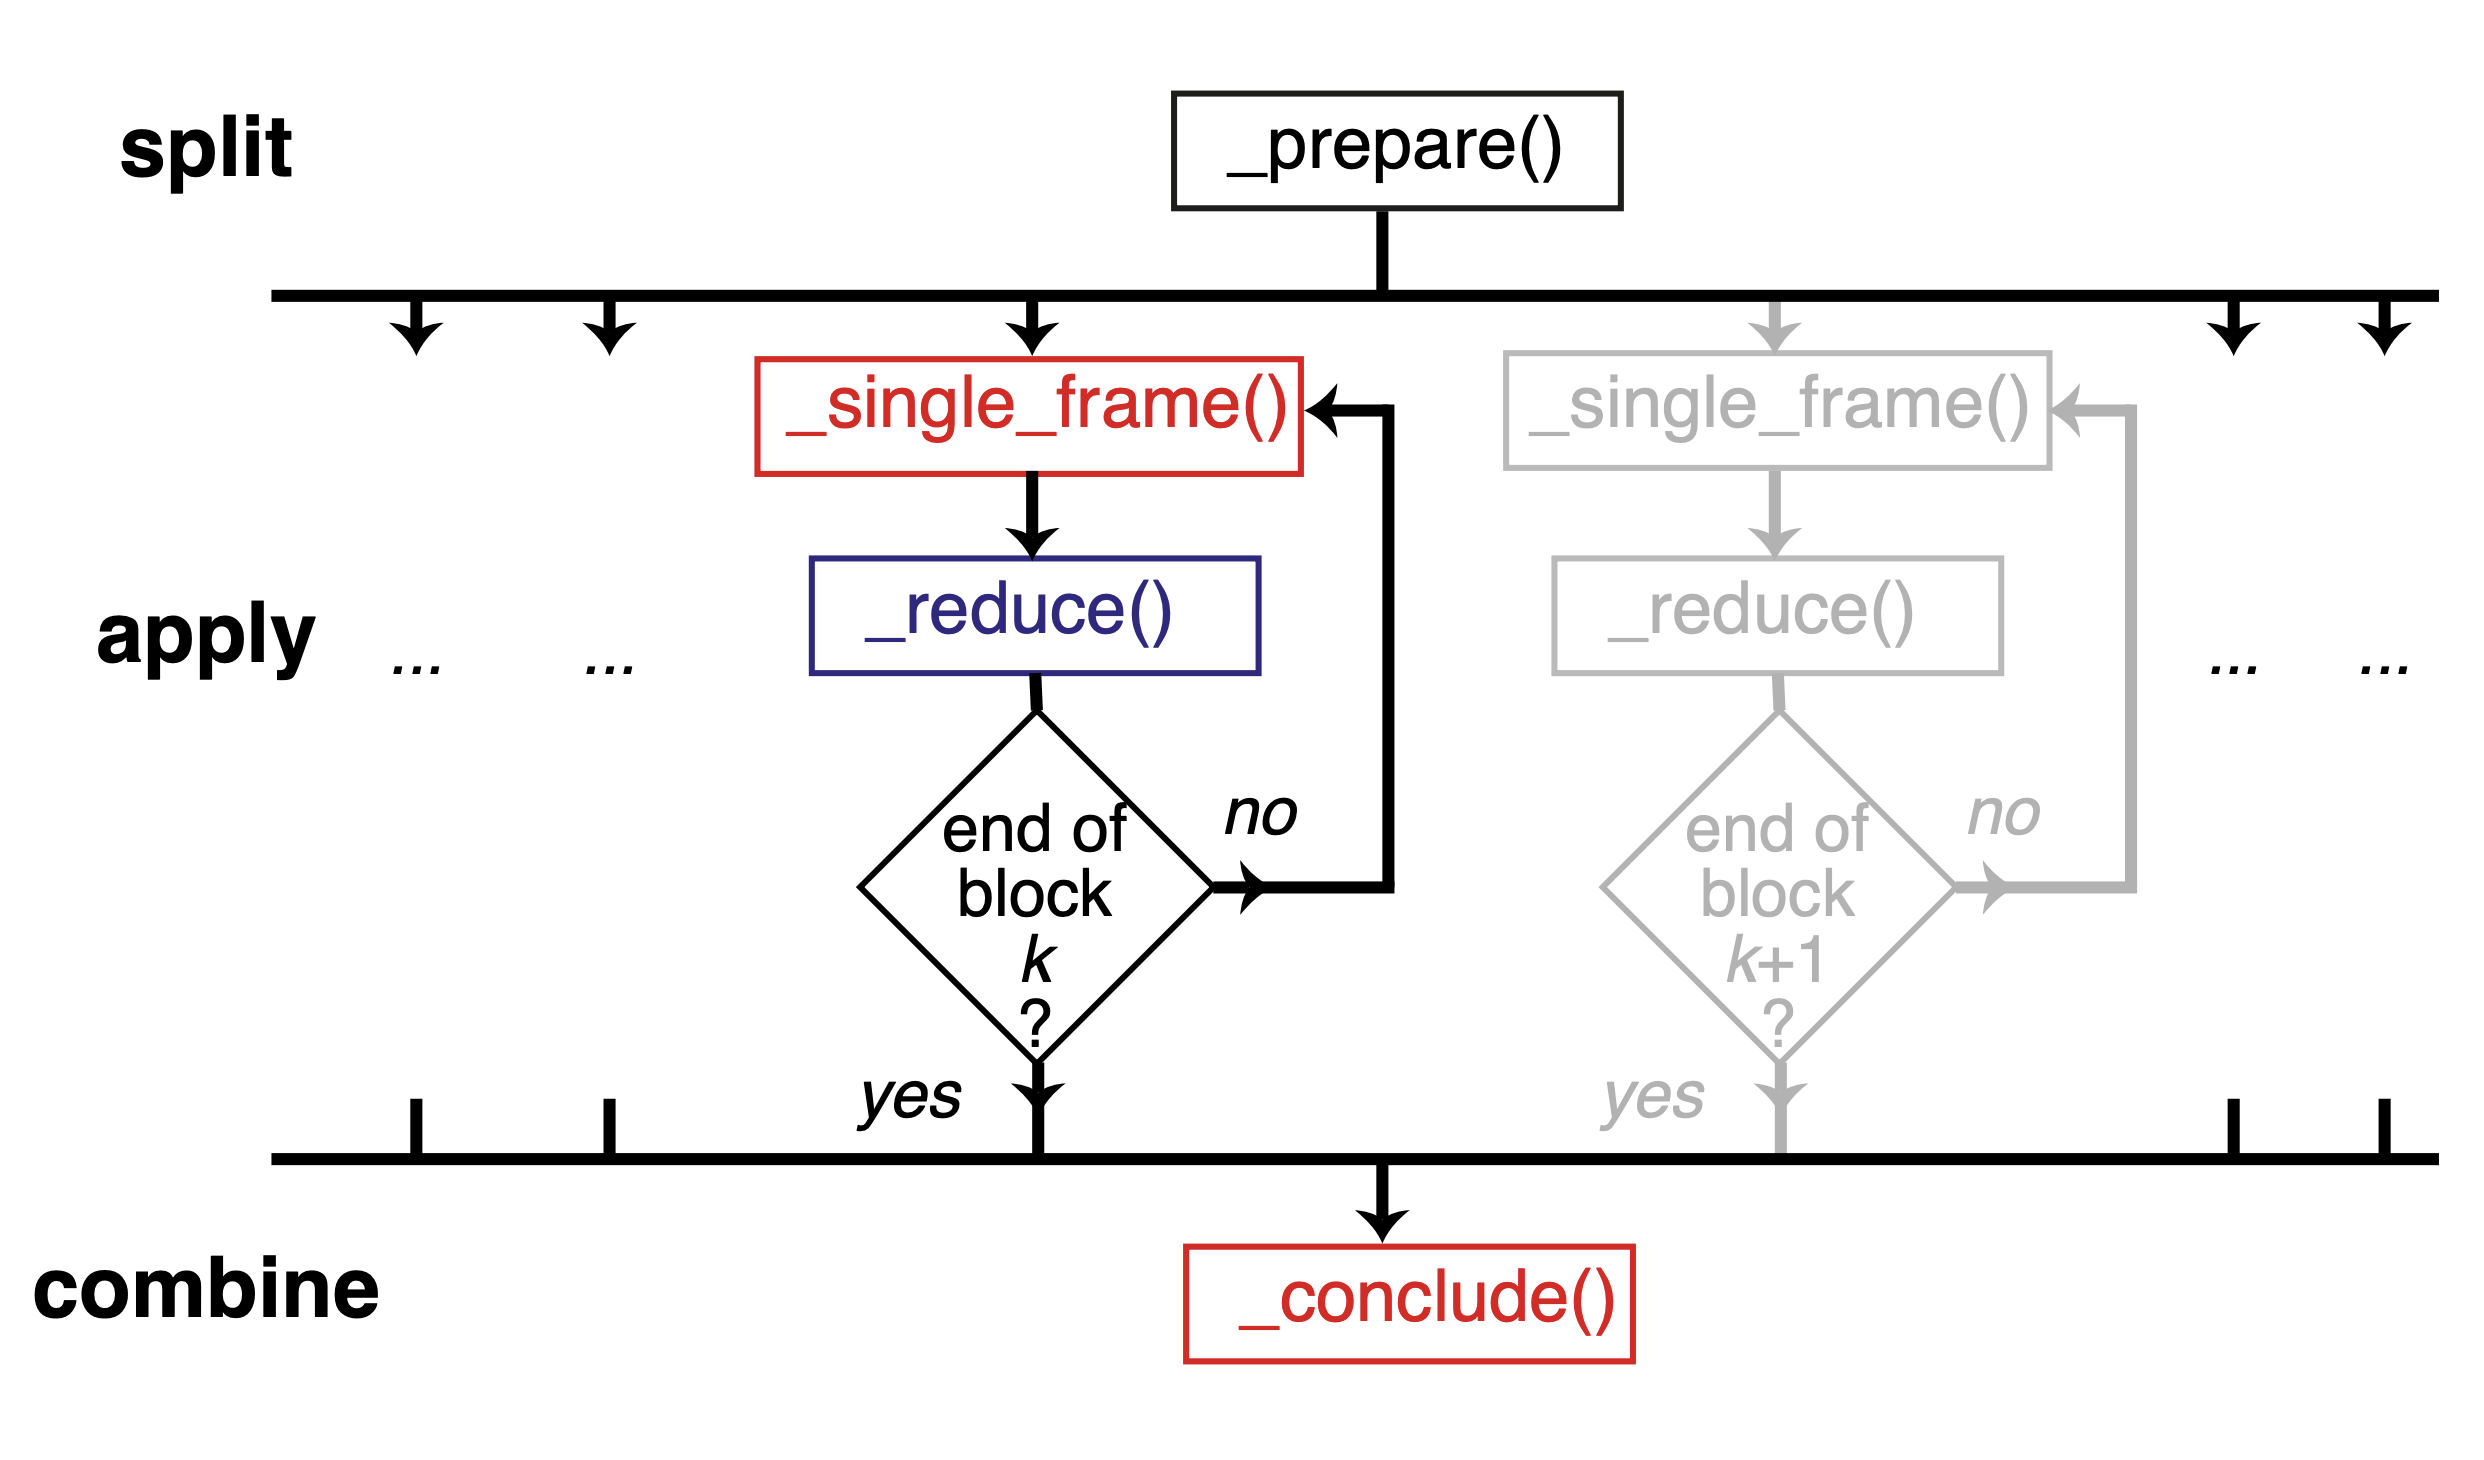
</div>

We will show a simple illustration of split-apply-combine approach with dask below:

### Apply in block function

In [19]:
@dask.delayed
def analyze_block(blockslice, func, *args, **kwargs): 
    result = [] 
    for ts in u.trajectory[blockslice.start:blockslice.stop]: 
        A = func(*args, **kwargs) 
        result.append(A) 
    return result

### Split the trajectory

In [20]:
n_frames = u.trajectory.n_frames
n_blocks = n_jobs   #  it can be any realistic value (0<n_blocks<=n_jobs)

frame_per_block = n_frames // n_blocks
blocks = [range(i * frame_per_block, (i + 1) * frame_per_block) for i in range(n_blocks-1)]
blocks.append(range(n_blocks * frame_per_block, n_frames))

In [21]:
blocks

[range(0, 348),
 range(348, 696),
 range(696, 1044),
 range(1044, 1392),
 range(1392, 1740),
 range(1740, 2088),
 range(2088, 2436),
 range(2436, 2784),
 range(2784, 3132),
 range(3132, 3480),
 range(3480, 3828),
 range(4176, 4187)]

### Apply the analysis per block

In [22]:
jobs = []
for bs in blocks:
    jobs.append(analyze_block(bs, radgyr, protein, protein.masses, total_mass=np.sum(protein.masses)))
jobs = dask.delayed(jobs)

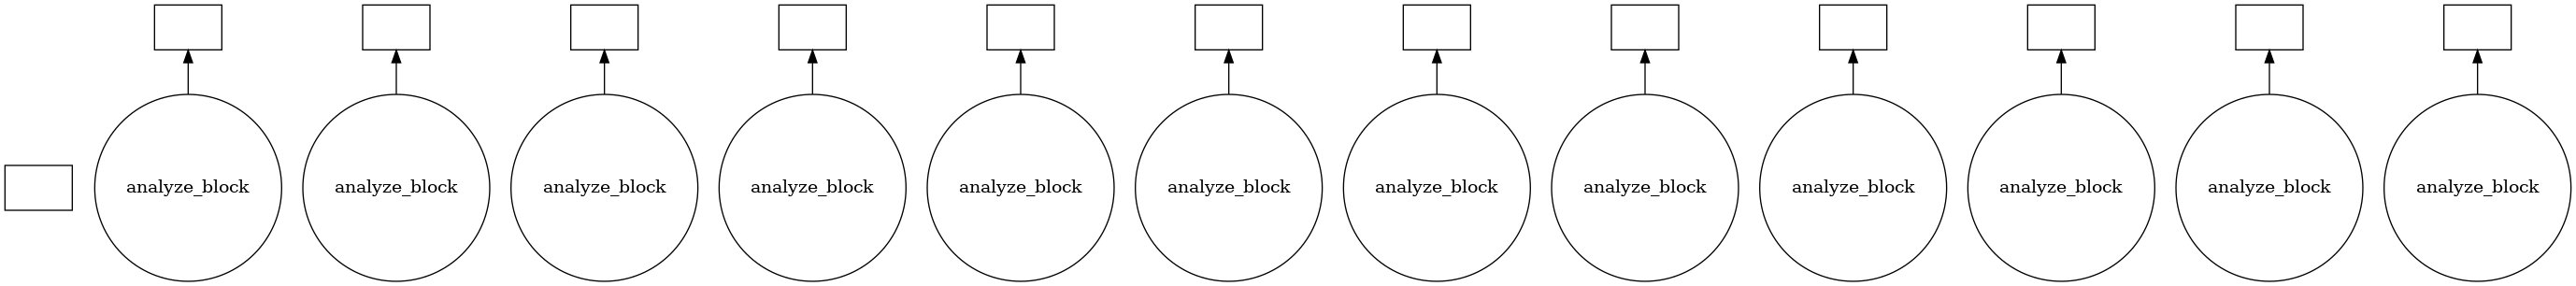

In [23]:
jobs.visualize()

In [24]:
results = jobs.compute()

### Combine the results

In [25]:
result = np.concatenate(results)

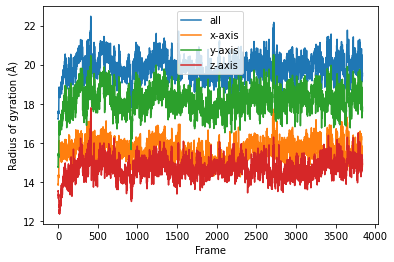

In [26]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

If you look at the Dask dashboard (with dask.distributed.Client) this time, you will see each green bar below reprsents a per-block analysis for `radgyr`.

<div>
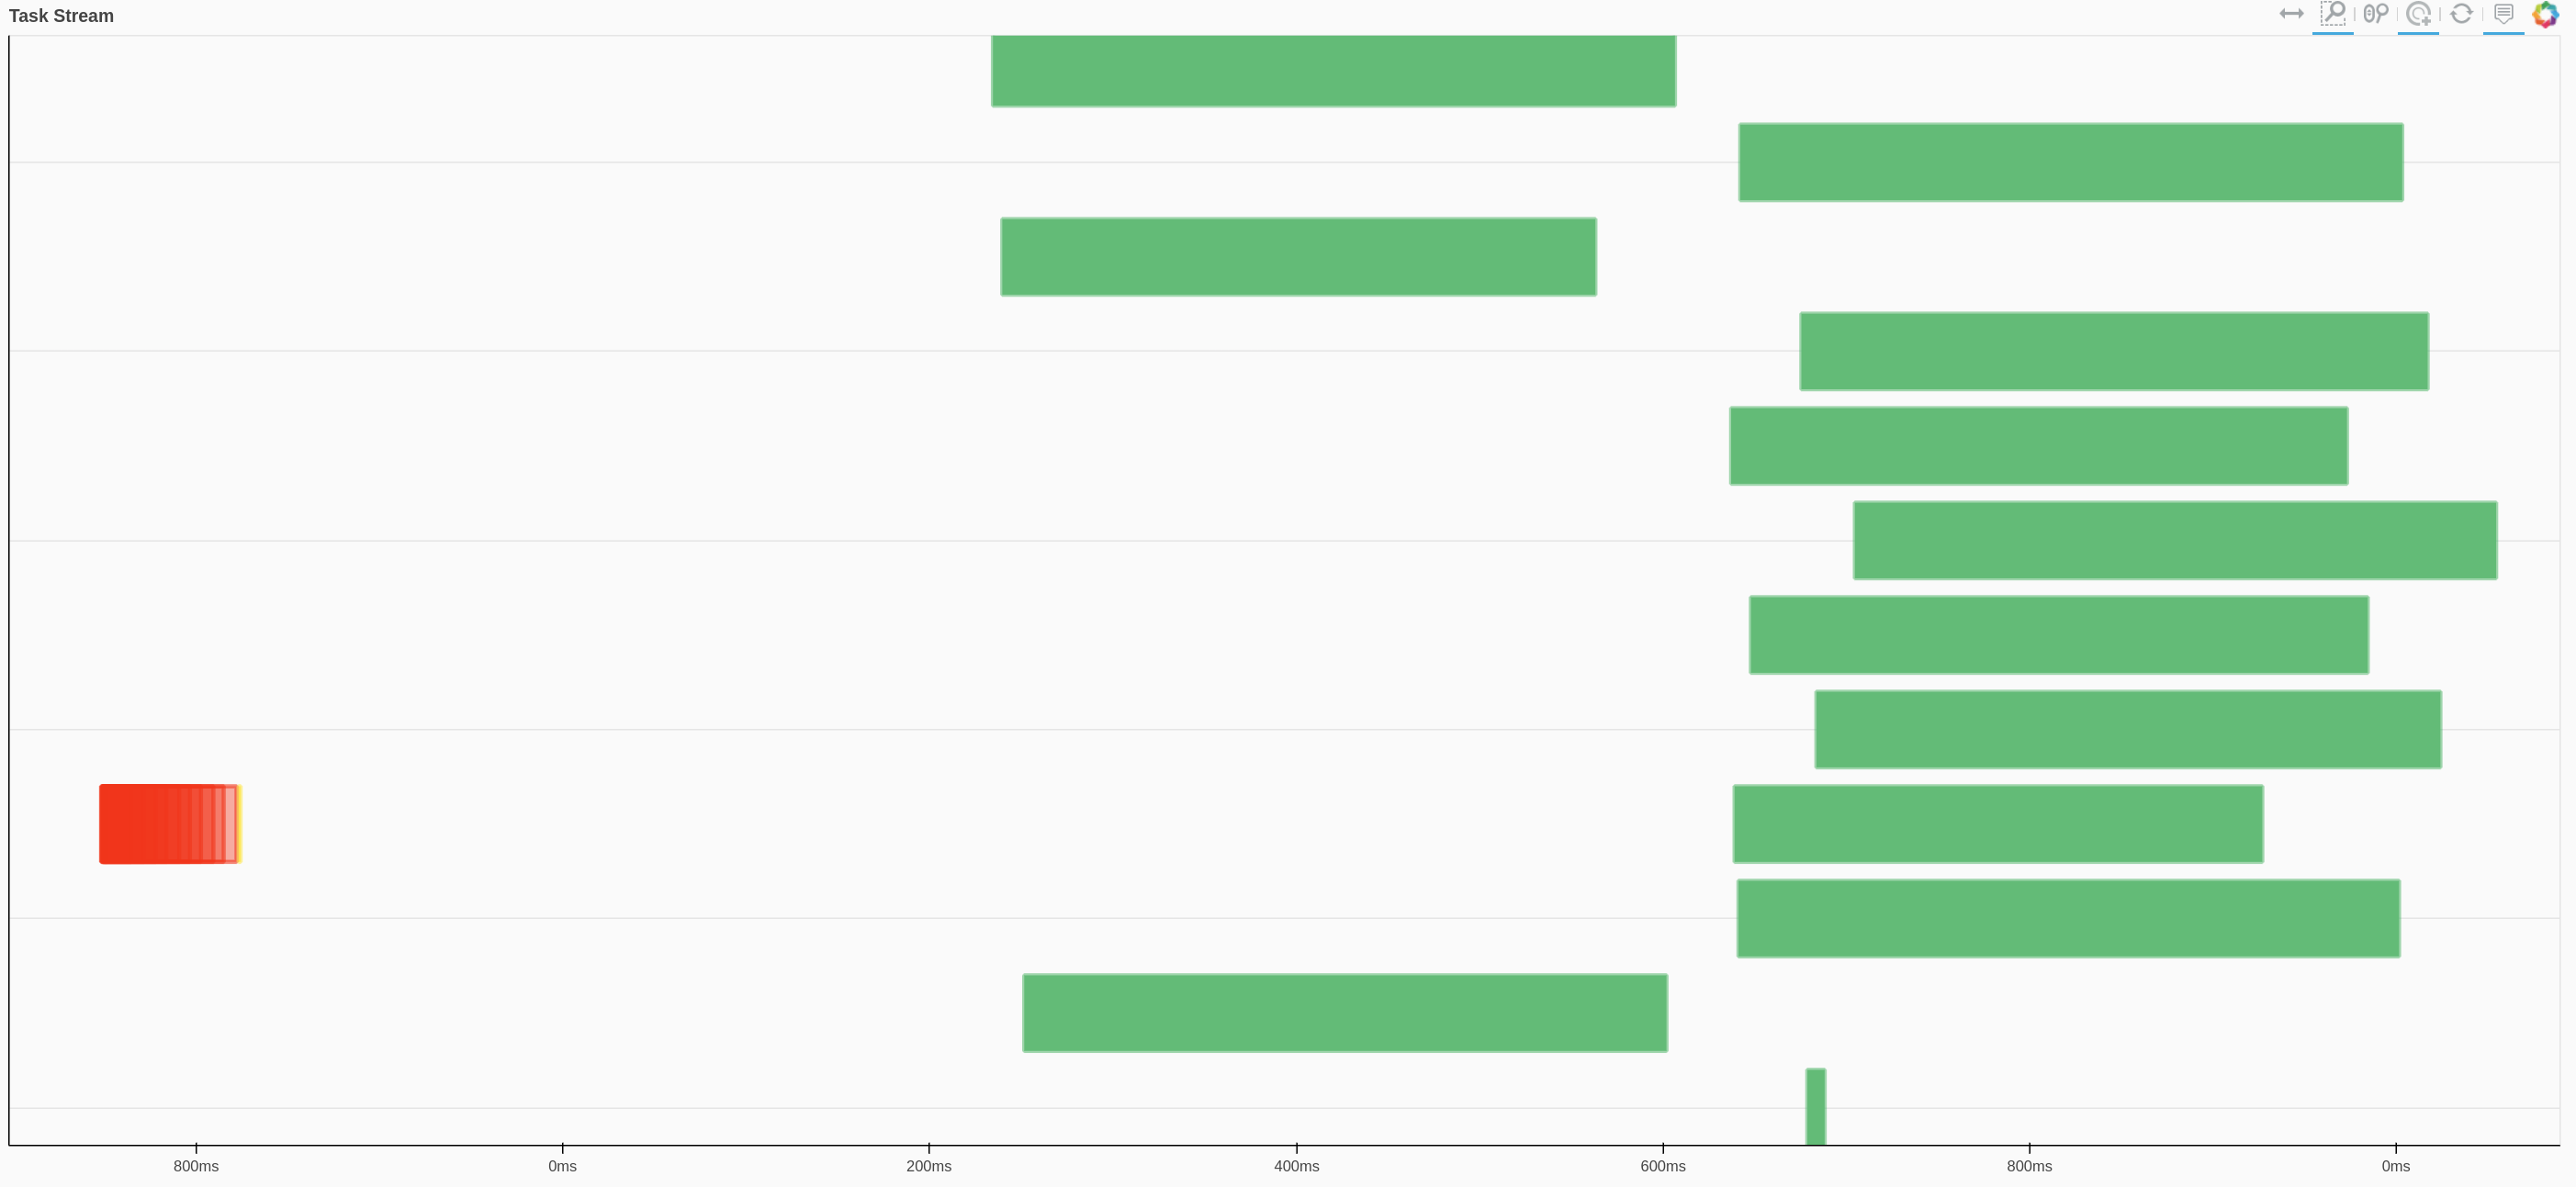
</div>

## Other possible parallelism approaches for multiple analyses

In real life, you may also want to perform multiple analyses (or analyzing multiple trajectories), you can use some high-level parallelism, i.e. running all the serial analyses in parallel.

Here we uses [`joblib`](https://joblib.readthedocs.io/en/latest/). It is deeply bound to `multiprocessing` that provides lightweight pipelining in Python. It has a simple API and convenient persistence of cached results.

In [27]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [28]:
def run_analysis(analysis):
    analysis.run()
    return analysis.results

In [29]:
# https://userguide.mdanalysis.org/1.0.0/examples/analysis/custom_trajectory_analysis.html#Creating-an-analysis-from-a-function

from MDAnalysis.analysis.base import AnalysisFromFunction 

In [30]:
rog_1 = AnalysisFromFunction(radgyr, u.trajectory,
                           protein, protein.masses,
                           total_mass=np.sum(protein.masses))

rog_2 = AnalysisFromFunction(radgyr, u.trajectory,
                           protein, protein.masses,
                           total_mass=np.sum(protein.masses))

rog_3 = AnalysisFromFunction(radgyr, u.trajectory,
                           protein, protein.masses,
                           total_mass=np.sum(protein.masses))

rog_4 = AnalysisFromFunction(radgyr, u.trajectory,
                           protein, protein.masses,
                           total_mass=np.sum(protein.masses))

analysis_ensemble = [rog_1, rog_2, rog_3, rog_4]

In [31]:
results_ensemble = Parallel(n_jobs=num_cores)(delayed(run_analysis)(analysis)
                                                for analysis in analysis_ensemble)

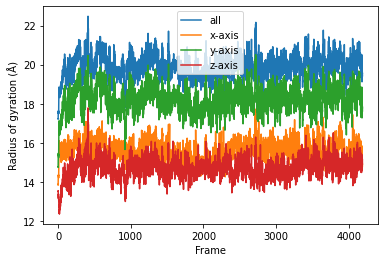

In [32]:
result_1 = np.asarray(results_ensemble[0]).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result_1, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

## See Also

The parallel version of MDAnalysis is still under development. For existing solution and some implemented parallel analysis, go to <a ref='https://www.mdanalysis.org/pmda/'>PMDA</a>. PMDA (<a data-cite="fan_pmda_2019" href="https://doi.org/10.25080/Majora-7ddc1dd1-013">Fan *et al.*, 2019</a>) applies the aforementioned split-apply-combine scheme with dask. In the future, it may provide a framework that consolidates all the mentioned parallel conditions.

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Shujie Fan, Max Linke, Ioannis Paraskevakos, Richard J. Gowers, Michael Gecht, and Oliver Beckstein. 
<span class="bibtex-protected">PMDA</span> - <span class="bibtex-protected">Parallel</span> <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Analysis</span>. 
<em>Proceedings of the 18th Python in Science Conference</em>, pages 134–142, 2019.
URL: <a href="https://conference.scipy.org/proceedings/scipy2019/shujie_fan.html">https://conference.scipy.org/proceedings/scipy2019/shujie_fan.html</a>, <a href="https://doi.org/10.25080/Majora-7ddc1dd1-013">doi:10.25080/Majora-7ddc1dd1-013</a> 